# 2019. 02. 08 시작
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard 커널 공부 및 번역하기

# Stacked Regressions to predict House Prices

## Serigne

### 2017년 7월
### 노트북의 일부를 사용하신다면, 이 노트북의 링크를 남겨주시면 감사하겠습니다.

이 컴피티션은 몇달전 제가 캐글을 시작할 때 많은 도움을 준 중요한 저에게 컴피티션 입니다. 
그 중 많은 좋은 노트북들을 읽을 수 있었고 몇가지 소개해드리겠습니다.

1. [Comprehensive data exploration with Python][1] by Pedro Marcelino: Great and very motivational data analysis

2. [A study on Regression applied to the Ames dataset][2] by Julien CohenSolal : Thorough featrues engineering and deep dive into linear regression analysis but really easy to follow for beginners.

3. [Regularized Linear Models][3] by Alexandru Papiu : Great Starter kernel on modelling and Cross-validation 

이 커널들이 처음 시작하는 모든 분들을 만족시켜주기는 어려울 수 있지만,(더 좋은 다른 커널들도 많습니다.), 데이터 사이언스와 캐글 컴피티션에 대한 감을 얻기에는 충분합니다.

기본적인 연습 후에는 Human Analog라는 사람이 쓴 [이 노트북][7]에서 Feature engineering에 대한 작업들을 살펴보며 조금 자신감을 가질 필요가 있습니다. 

이 데이터셋은 특히 쉽게 다룰 수 있기 때문에, 배웠던 내용 중 스태킹 모델을 적용해보려고 합니다. 이번 노트북에서 2종류의 방식으로 만들어보겠습니다.

두 방식들은 일반적인 목적으로 사용될 수 있고, 쉽게 적용하거나 또는 다른 회귀 문제에도 확장할 수 있습니다. 전반적으로 간결하고 쉽게 살펴보겠습니다.

우리가 사용할 Feature engineering 기법은 다른 노트북들에 비해 어렵지 않습니다.

- **결측치 대체(Imputing missing values)** 데이터의 변수를 순차적으로 하나하나 결측치를 대체합니다.

- **변환(Transforming)** 범주형 데이터로 보이는 수치적 데이터를 변환합니다.

- **라벨 인코딩(Label Encoding)** 몇몇 범주형 데이터는 순서가 있는 집합으로 되어있는 정보를 가지고 있는 경우가 있으므로 라벨 인코딩을 합니다.

-  [**Box Cox Transformation**][4] 치우친 변수에 대해 (log-변환 대신에 사용하는 방법) : 이 방법은 조금이지만 LB와 CV에서 **더 좋은 결과**를 보여주었기 때문에 사용합니다.

- **더미 변수 만들기(Getting dummy variables)** 범주형 변수에서 더미 변수로 One-hot encoding 합니다.

이제 베이스로 사용할 모델을 선택해야하는데, 대부분은 sklearn의 모델을 사용하고, [XGBoost][5], [LightGBM][6] 그리고 스태킹 모델과 앙상블을 하기전에 CV를 통해 검증을 하려고합니다. 핵심은 (선형)모델을 이상치에 민감하지 않은(robust) 모델을 만들어야 한다는 점 입니다. 이는 LB와 CV 모두에서 향상된 결과를 보여줍니다.

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso

2017년 7월 2일 LB에서 0.11420으로 상위 4% 결과를 얻을 수 있었습니다.

** 모든 분들이 이 노트북을 다 살펴 보았을 때, 스태킹 방식이 명확하게 이해되었으면 좋겠습니다.**

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x : '{:.3f}'.format(x))

from subprocess import check_output
print(check_output(['ls', './input']).decode('utf8'))

data_description.txt
sample_submission.csv
test.csv
train.csv



In [2]:
# 판다스 데이터 프레임으로 train, test 데이터를 불러옵니다.

train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [3]:
#train 데이터셋에서 앞의 5개 데이터를 살펴봅니다.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#test 데이터셋에서 앞의 5개 데이터를 살펴봅니다.
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# 데이터 샘플의 수와, 변수의 개수 확인
print('Id 컬럼을 제거하기 전의 train 데이터의 차원 : {}'.format(train.shape))
print('Id 컬럼을 제거하기 전의 test 데이터의 차원 : {}'.format(test.shape))

# Id 컬럼을 따로 변수로 저장합니다.
train_ID = train['Id']
test_ID = test['Id']

#Id 컬럼을 제거합니다. axis=1은 데이터 샘플 축 방향이고, inplace는 데이터 프레임에 바로 해당 함수 적용 유무 입니다.
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Id 컬럼을 제거하고, 데이터 샘플의 수와 변수 개수 확인
print('\nId 컬럼을 제거한 후의 train 데이터의 차원 : {}'.format(train.shape))
print('Id 컬럼을 제거한 후의 test 데이터의 차원 : {}'.format(test.shape))


Id 컬럼을 제거하기 전의 train 데이터의 차원 : (1460, 81)
Id 컬럼을 제거하기 전의 test 데이터의 차원 : (1459, 80)

Id 컬럼을 제거한 후의 train 데이터의 차원 : (1460, 80)
Id 컬럼을 제거한 후의 test 데이터의 차원 : (1459, 79)


# 데이터 처리

## 이상치
the Ames Housing Data 문서에서 train 데이터셋에 이상치가 존재한다고 나와 있었습니다.
<br><br>

확인해보겠습니다.

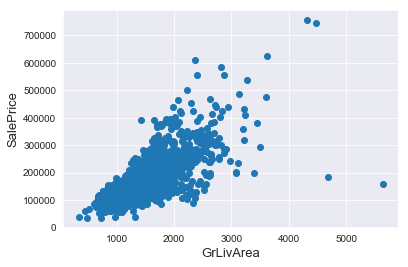

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

오른쪽 하단에 2개의 극도로 큰 GrLivArea 값을 가지면서 낮은 가격을 갖는 데이터를 살펴볼 수 있습니다.<br>
이러한 값들은 명확하게 이상치로 판단할 수 있습니다. 데이터셋에서 제거하겠습니다.

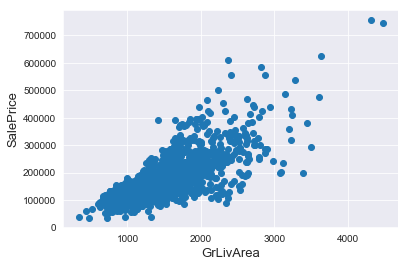

In [7]:
#이상치 제거
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice']<300000)].index)

#시각화로 확인
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#### Note:
이상치 제거는 반드시 해야합니다. 모델에 안좋은 영향을 끼칠 수 있기 때문입니다.
<br>
확률적으로 train 데이터셋에 다른 이상치가 있을 수 있습니다. 하지만 test 데이터셋에도 이상치가 존재할 수 있기 때문에  그러한 데이터를 전부 제거하는 것 또한 모델에 안좋은 영향을 끼칠 수 있습니다.<br>
이러한 이유에서 전부 제거하는 것 대신에 이상치에 민감하지 않은(robust) 모델을 만들어야 한다는 것 입니다.<br>
모델링 부분에서 다시 살펴보겠습니다.

## Target 변수

<br>
**SalePrice**는 예측에 필요한 변수입니다. 그러니 해당 변수를 먼저 분석해 보겠습니다.


 평균 = 180932.92, 표준 편차 = 79467.79



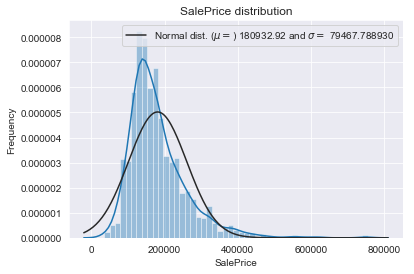

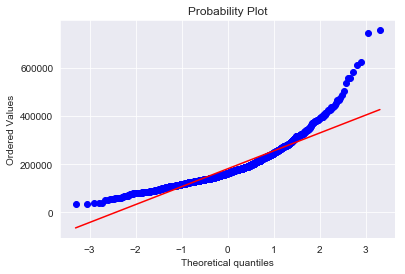

In [8]:
# 분포를 살펴봅니다.
sns.distplot(train['SalePrice'], fit=norm)

# 해당 변수의 평균과 표준 편차를 구합니다.
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n 평균 = {:.2f}, 표준 편차 = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$) {:.2f} and $\sigma=$ {:2f}'.format(mu, sigma)],
          loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot을 그립니다. 실제 분포와 해당 데이터셋이 추출된 분포의 차이를 살펴볼 수 있습니다.
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Target 변수가 오른쪽으로 치우친 것을 확인할 수 있습니다.(선형) 모델은 정규 분포된 데이터를 좋아하기 때문에, 데이터 분포를 정규 분포와 비슷하게 변환할 필요가 있습니다. <br>


#### target 의 Log-변환


 평균 = 12.02, 표준 편차 = 0.40



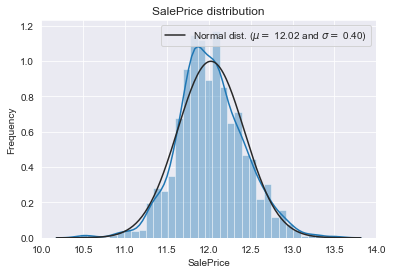

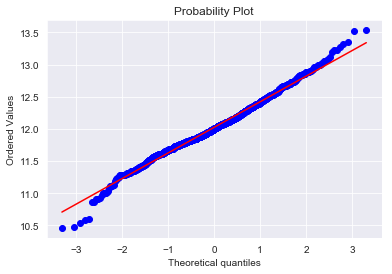

In [9]:
# log(1+x) 모든 컬럼에 1을 더해서 로그화 시키는 numpy 함수를 사용합니다.(변수의 값이 1보다 작으면 -1를 나타내기
# 때문에 이런 함수를 사용하는 것으로 보입니다.)
train['SalePrice'] = np.log1p(train['SalePrice'])

# 새로운 분포 확인
sns.distplot(train['SalePrice'], fit=norm)

# 새로운 분포의 평균, 표준편차를 얻습니다.
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n 평균 = {:.2f}, 표준 편차 = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
          loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot을 그립니다. 실제 분포와 해당 데이터셋이 추출된 분포의 차이를 살펴볼 수 있습니다.
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

## 2019. 02. 24
이전 부분 한글 번역함.

치우침이 조금 완화 되었고, 데이터가 정규 분포를 띄는 것처럼 분포를 조정하였습니다.

### Features engineering

먼저 train 데이터와 test 데이터를 하나로 합쳐 같이 처리할 수 있도록 합니다.

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
# reset_index, drop을 True로 하면 index 컬럼을 새로 추가하지 않는다.
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print('데이터 전체 크기 : {}'.format(all_data.shape))

데이터 전체 크기 : (2917, 79)


## 2019. 02. 27
### 결측 데이터

In [11]:
# 결측치를 백분율로 표현
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
# all_data_na에서 값이 0이라는건 결측치가 없다는 의미이므로 그 부분은 버리고,
# 결측치가 존재하는 부분에서 30개 정도 변수로 저장, 내림차순.
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'결측률' : all_data_na})
# 20개만 확인.
missing_data.head(20)

,결측률
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


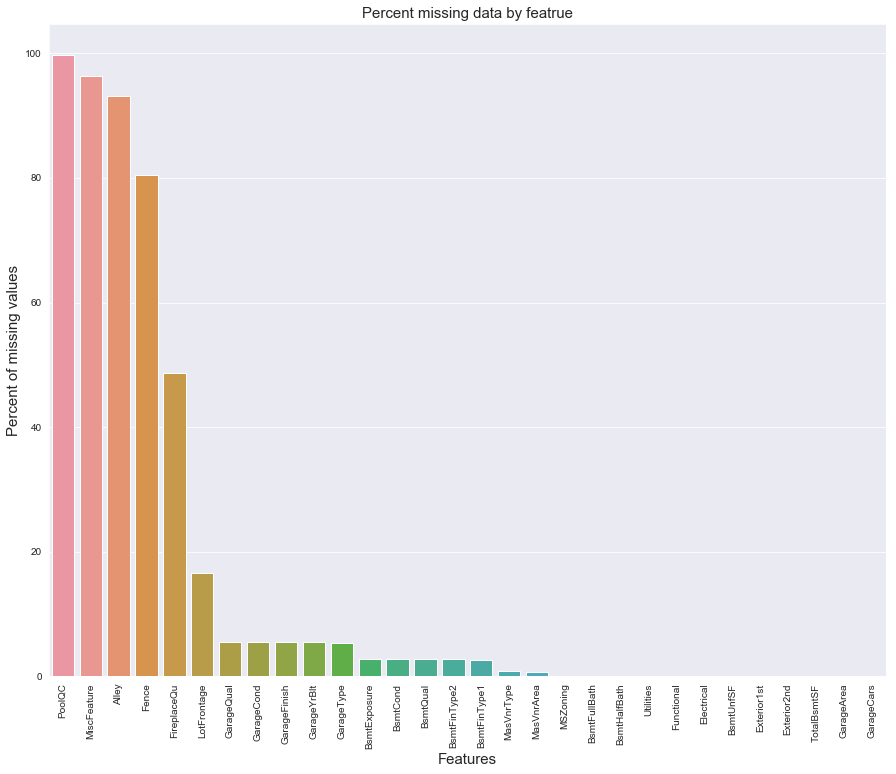

In [12]:
# 막대 그래프를 그리기 위한 subplot
f, ax = plt.subplots(figsize=(15, 12))
# x축 라벨의 길이가 길기 때문에 라벨을 세로로 세워서 보이도록 돌립니다.
plt.xticks(rotation='90')
# 막대 그래프 그리기, x축은 라벨, y축은 결측 백분율.
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by featrue', fontsize=15)
plt.show()

### 데이터 상관관계
Target 변수인 SalePrice와 다른 변수들이 어떤 상관 관계를 가지고 있는지 살펴보겠습니다.<br>
오른쪽 바를 기준으로 밝을 수록 1에 가까우니 양의 상관 관계, 어두울 수록 -1에 가까우니 음의 상관 관계, 중간의 경우에는 0의 상관 관계를 가집니다.

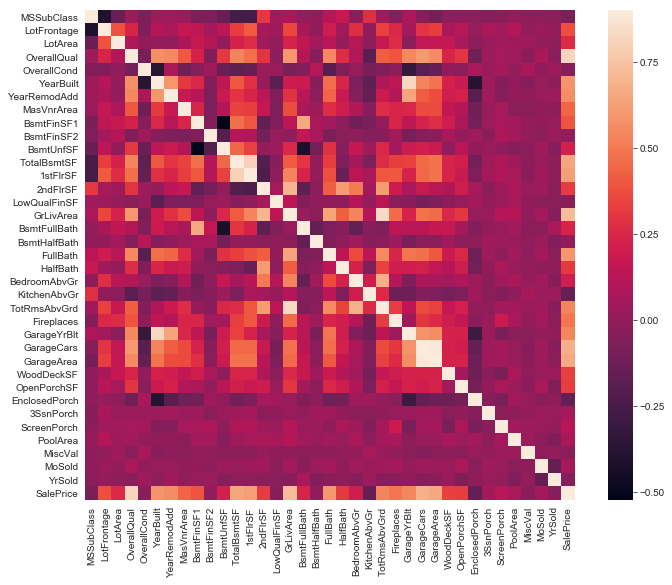

In [13]:
# Dataframe.corr() 함수를 통해 해당 df 변수들간 상관 관계 행렬을 얻을 수 있습니다.
corrmat = train.corr()
plt.subplots(figsize=(12, 9))
# seaborn.heatmap() 함수로 상관 관계 행렬을 그릴 수 있습니다.
# Confusion matrix를 표현할 때도 사용하기도 합니다.
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

### 결측치 대체하기. (Imputing)
결측치를 가진 변수들을 순차적으로 하나하나 처리해보겠습니다.

- **PoolQC** : 이 변수가 NA 값을 나타내면, 집에 "풀장이 없다" 라는 의미로 생각할 수 있습니다. 결측률이 99%이고, 일반적으로 많은 수의 집이 풀장이 없는 것을 생각해볼 때 'None'으로 값을 대체해도 무방합니다.

In [14]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

- **MiscFeature** : 이 변수가 NA 값을 나타내면, 기타 사항이 없다는 의미이므로 'None'으로 값을 대체합니다.

In [15]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

- **Alley** : 이 변수가 NA 값을 나타내면, 뒷골목이 없다는 의미이므로 'None'으로 값을 대체합니다.

In [16]:
all_data['Alley'] = all_data['Alley'].fillna('None')

- **Fence** : 이 변수가 NA 값을 나타내면, 울타리가 없다는 의미이므로 'None'으로 값을 대체합니다.

In [17]:
all_data['Fence'] = all_data['Fence'].fillna('None')

- **FireplaceQu** : 이 변수가 NA 값을 나타내면, 벽난로가 없다는 의미이므로 'None'으로 값을 대체합니다.

In [18]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

- **LotFrontage** : 이 변수는 길과 집이 연결된 직선의 거리를 나타내는 변수로, Neighborhood 변수가 나타내는 에임즈 시내의 같은 구역들이라면 비슷한 값을 나타낼 것으로 예상되니 같은 구역 내의 중간 값으로 대체하겠습니다.

In [19]:
# Group by를 통해 Neighborhood 변수를 묶고, 그 중 LotFrontage 변수의 결측치를 중간 값으로 채웁니다.
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x : x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : 이 변수가 NA 값을 나타내면 차고지가 없다는 의미이므로 'None'으로 값을 대체합니다.

In [20]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : 이 변수가 NA 값을 나타내면 차고가 없기 때문에 차고를 지은지 얼마나 되었는지, 크기는 얼마나 되는지, 차는 몇대 들어가는지 등의 값을 나타낼 수 없습니다. 0으로 대체합니다.

In [21]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : 이 변수들은 지하에 관련된 수치적 변수이므로 NA 값을 갖는 경우 0으로 값을 대체합니다.

In [22]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : 이 변수들은 모두 지하에 관련된 범주형 변수이므로 NA 값을 갖는 경우 'None'으로 값을 대체합니다.

In [23]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

## 2019. 02. 28

- **MasVnrArea and MasVnrType** : 이 변수는 집의 외벽이 벽돌로 지어져 있는지에 대한 변수입니다. NA 값을 나타낸다면, Type은 'None'으로 Area는 0으로 대체합니다.

In [24]:
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')

- **MSZoning** : 이 변수는 일반적인 지역 분류를 나타내는 변수로 'RL'이 가장 일반적인 값(최빈값)입니다. NA 값을 'RL'로 대체합니다.

In [25]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(
    all_data['MSZoning'].mode()[0])

- **Utilities** : 이 변수는 범주형 변수로 1개의 'NoSeWa', 2개의 결측치를 제외하고는 모두 'AllPub' 값을 가지고 있습니다. 이러한 변수는 예측 모델에게 좋은 영향을 주지 않으므로 변수 자체를 제거하겠습니다.

In [26]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : 데이터 명세에서 NA 값은 typical을 의미한다고 했으니 'Typ' 값으로 대체합니다.

In [27]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

- **Electrical** : 이 변수는 1개의 결측치를 가지고 있으므로, 최빈값인 'SBrkr' 값으로 대체합니다.

In [28]:
all_data['Electrical'] = all_data['Electrical'].fillna(
    all_data['Electrical'].mode()[0])

- **KitchenQual** : 이 변수도 1개의 결측치를 가지고 있습니다. Electrical 변수와 동일하게 최빈 값인 'TA' 값으로 대체합니다.

In [29]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(
    all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : 이 두 변수도 1개의 결측치를 가지고 있습니다. 최빈값인 'VinylSd' 값으로 대체합니다.

In [30]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(
    all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(
    all_data['Exterior2nd'].mode()[0])

- **SaleType** : 이 변수도 최빈값 'WD'로 대체합니다.

In [31]:
all_data['SaleType'] = all_data['SaleType'].fillna(
    all_data['SaleType'].mode()[0])

- **MSSubClass** : 이 변수가 NA 값을 나타내면, 건물 등급이 없는 것으로 처리하여 'None' 값으로 대체합니다.

In [32]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna('None')

아직도 결측치가 존재하는 변수가 남았는지 확인해보겠습니다.

In [33]:
all_data_na = (all_data.isnull().sum() / len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data.head()

,Missing Ratio


이제 결측치가 존재하는 변수가 남아있지 않습니다.

### More feature engineering
조금 더 전처리 해보겠습니다.
#### 몇개의 수치형 변수를 범주형 변수로 변경

In [34]:
# MSSubClass 변수는 건물의 등급이므로 범주형 변수로 변경합니다.
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# OverallCond 변수는 전반적인 상태를 나타내는 변수이므로 범주형 변수로 변경합니다.
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
# 이 부분에서 MSSubClass, OverallCond 변수 모두 수치형 변수를 문자열로 변환하는데, apply, astype 두 가지
# 방법으로 변환한 이유는 MSSubClass 변수에는 결측치를 대체하며 'None' 변수를 추가하였기 때문에 apply로 변환합니다.

# YrSold, MoSold는 언제 집을 구매했는지에 대한 변수이므로 범주형 변수로 변경합니다.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### 순서가 있는 범주형 변수는 라벨 인코딩을 통해 변경

In [35]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

# 컬럼 별로 라벨 인코딩 처리 합니다.
for c in cols:
    lbl = LabelEncoder()
    all_data[c] = lbl.fit_transform(list(all_data[c].values))
    
# 데이터 차원 확인
print('all_data의 모양: {}'.format(all_data.shape))

all_data의 모양: (2917, 78)


#### 중요한 변수 추가
집의 면적은 집값을 결정하는데, 중요한 요인입니다.<br>
지하, 1층, 2층의 면적을 모두 더해 집의 전체 면적을 나타내는 새로운 변수를 추가하겠습니다.

In [36]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### 치우친 형태의 분포를 가진 수치형 변수 처리

In [37]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

# 모든 수치형 변수의 치우침 확인 scipy의 skew 함수를 통해 확인할 수 있습니다. 
# skew 함수의 반환 값은 양수인 경우 오른쪽으로, 음수인 경우 왼쪽으로 분포가 치우침을 의미하고
# 0인 경우 고르게 분포 되었음을 의미합니다.
skewed_feats = all_data[numeric_feats].apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)
print('수치형 변수들의 치우친 정도')
skewness = pd.DataFrame({'치우친 정도' : skewed_feats})
skewness.head(10)

수치형 변수들의 치우친 정도


,치우친 정도
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


#### Box Cox 변환을 통한 심하게 치우친 변수 처리
Box Cox 변환은 정규분포가 아닌 변수를 정규분포로 변환하기 위해 사용하는 방법입니다.<br>
λ를 조절하여 가장 정규성을 높여주는 값을 찾아 사용합니다. λ=0인 경우 log 변환과 동일합니다.<br>

In [38]:
skewness = skewness[abs(skewness) > 0.75]
print('Box Cox 변환을 할 변수의 수 : {}개'.format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

Box Cox 변환을 할 변수의 수 : 59개


#### 범주형 변수에 대해 더미 변수 만들기

In [39]:
# pandas의 get_dummies() 함수를 통해 범주형 변수로부터 더미 변수를 만들 수 있습니다.
# 이를 One-hot-Encoding 이라고도 합니다.
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


데이터 전처리를 마무리하고 Train, Test으로 데이터를 나눕니다.

In [40]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Modeling
#### Import libraries

In [41]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

#### Cross Validatiuon 함수 정의하기
sklearn의 cross_val_score 함수를 사용해서 모델을 평가할 수 있습니다.<br>
하지만 이 함수는 데이터 샘플들을 섞지 않으므로, KFold를 사용해 섞어 검증하겠습니다.

In [42]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, 
                                    scoring='neg_mean_squared_error', cv=kf))
    return rmse

### Base models
- **LASSO Regression** : 이 모델은 이상치에 매우 민감하게 작동합니다. 그래서 모델이 민감하게 작동하지 않도록 만들 필요가 있습니다. 모델 파이프라인에 sklearn의 Robustscaler() 함수를 추가해 모델이 이상치에 둔감하게 만들겠습니다.

In [43]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

- **Elastic Net Regression** : 이 모델도 동일하게 이상치에 둔감하도록 RobustScaler를 추가합니다.

In [44]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9,
                                               random_state=3))

- **Kernel Ridge Regression**

In [45]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression** : 이 모델도 이상치에 둔감하도록 huber 비용 함수를 사용합니다.

In [46]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                  max_depth=4, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10,
                                  loss='huber', random_state=5)

- **XGBoost**

In [47]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                            learning_rate=0.05, max_depth=3,
                            min_child_weight=1.7817, n_estimators=2200,
                            reg_alpha=0.4640, reg_lambda=0.8571,
                            subsample=0.5213, slient=1,
                            random_state=7, nthread=-1)

- **LightGBM**

In [48]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leabes=5,
                             learning_rate=0.05, n_estimators=720,
                             max_bin=55, bagging_fraction=0.8,
                             bagging_freq=5, feature_fraction=0.2319,
                             feature_fractrion_seed=9, bagging_seed=9,
                             min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

#### Base models scores
지금까지 정의한 모델들의 cross validation rmsle error를 살펴보고 성능을 평가해보겠습니다.

In [1]:
score = rmsle_cv(lasso)
print('Lasso score : {:.4f} ({:.4f})'.format(score.mean(), score.std()))

NameError: name 'rmsle_cv' is not defined

In [50]:
score = rmsle_cv(ENet)
print('ElasticNet score : {:.4f} ({:.4f})'.format(score.mean(), score.std()))

ElasticNet score : 0.1116 (0.0074)


In [51]:
score = rmsle_cv(KRR)
print('Kernel Ridge score : {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Kernel Ridge score : 0.1153 (0.0075)


In [52]:
score = rmsle_cv(GBoost)
print('Gradient Boosting score : {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Gradient Boosting score : 0.1177 (0.0080)


In [53]:
score = rmsle_cv(model_xgb)
print('XGBoost score : {:.4f} ({:.4f})'.format(score.mean(), score.std()))

XGBoost score : 0.1156 (0.0063)


In [54]:
score = rmsle_cv(model_lgb)
print('LGBM score : {:.4f} ({:.4f})'.format(score.mean(), score.std()))

LGBM score : 0.1213 (0.0063)


### Stacking models
#### 가장 간단한 Stacking 방법 : Averaging base models
base 모델의 결과의 산술 평균을 통한 방법으로 가장 쉽게 Stacking을 해볼 수 있습니다.<br>
Stacking을 위한 클래스를 정의하겠습니다.

In [55]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    # 원본 모델을 복사하여, 학습시키는 함수
    def fit(self, X, y):
        # 원본 모델들을 복사합니다.
        self.models_ = [clone(x) for x in self.models]
        
        # 복사한 모델들을 학습시킵니다.
        for model in self.models_:
            model.fit(X, y)
            
        return self
    
    # 복사한 모델들의 평균으로 결과를 반환하는 함수
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

#### Averaging base models 방법의 score 확인
ENet, GBoost, KRR and Lasso 4개의 모델을 산술 평균 Stacking으로 결과를 살펴보겠습니다.

In [56]:
averaged_models = AveragingModels(models=(ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print('Averaged base models score : {:.4f} ({:.4f})'.format(
score.mean(), score.std()))

Averaged base models score : 0.1091 (0.0075)


간단한 Stacking 방법으로도 더 좋은 성능을 낼 수 있었습니다.<br>

#### 덜 간단한 Stacking 방법 : Meta-model 추가하기
이번에는 K-Fold를 사용한 Average Stacking과 함께 Meta-model을 하나 더 추가하여 Stacking을 해보겠습니다. (Train은 가지고 있는 데이터, train은 kfold로 분리한 데이터 중 학습에 사용하는 데이터입니다.)
1. Train 데이터를 상호 배타적(disjoint, 서로소)으로 분리(train, holdout)합니다.
2. 분리한 train 데이터를 사용해 base 모델들을 학습합니다.
3. 분리한 holdout 데이터를 학습한 base 모델로 예측합니다.
4. 3.에서 나온 예측 값을 새로운 변수로하여 Meta-model을 학습합니다.

- 학습 단계
1~3번 단계는 반복적으로 Train 데이터를 쪼갠 만큼 수행합니다. 만약 5-fold stacking이라면, Train 데이터를 5개로 쪼개고 5번 반복합니다. 매 반복마다 4개의 fold는 학습(train)에 사용되고 1개의 fold는 Meta-model의 변수로 사용하기 위해 예측(holdout)에 사용됩니다.

이 노트북에서는 데이터를 5개로 쪼개어, 1~3 단계를 5번 반복하고 각 단계마다 나온 holdout의 예측값을 사용해 Meta-model을 학습합니다. 

- 예측 단계
5개의 base 모델과, 1개의 Meta-model을 학습했다면, 5개의 base 모델은 Test 데이터를 예측하도록하고, 나온 예측 값을 입력으로 Meta-model이 최종 예측 값을 반환하도록 합니다.<br>
![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

#### Stacking Averaged Models Class

In [57]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X,y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

#### Stacking Averaged models Score
두개의 Stacking 방법을 비교할 수 있도록 ENet, KRR and GBoost를 Average Base 모델로 사용하고, Lasso를 Meta-model로 사용하겠습니다.

In [58]:
stacked_averaged_models = StackingAveragedModels(
    base_models=(ENet, GBoost, KRR), meta_model=lasso)

score = rmsle_cv(stacked_averaged_models)
print('Stacking Averaged models score : {:.4f} ({:.4f})'.format(
    score.mean(), score.std()))

Stacking Averaged models score : 0.1084 (0.0074)


Meta-model을 추가해서 더 좋은 성능을 얻을 수 있었습니다.

### StackedRegressor, XGBoost and LightGBM 앙상블
XGBoost와 LightGBM를 방금 정의한 StackedRegressor와 함께 앙상블을 해보겠습니다.<br>
먼저 Error 함수를 간단히 다시 정의하겠습니다.

In [59]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction
#### StackedRegressor

In [60]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07814905151548944


#### XGBoost

In [61]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07872027124385908


#### LightGBM

In [62]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.010987801404237277


In [63]:
print('RMSLE score on train data')
print(rmsle(y_train, stacked_train_pred*0.7 + xgb_train_pred*0.15 + 
           lgb_train_pred*0.15))

RMSLE score on train data
0.06651755263109074


#### Ensemble predictions

In [64]:
ensemble = stacked_pred*0.7 + xgb_pred*0.15 + lgb_pred*0.15

#### Submission

In [65]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv', index=False)